### Run the Database Connection File

In [32]:
%run ./db_connections.ipynb

### Import the Necessary Packages and Libraries

In [33]:
#!pip install pymongo
#!pip install psycopg2
#!pip install wordcloud
import pymongo
import requests
import pandas as pd
import numpy as np
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy import exc
from sqlalchemy import inspect

### Load the Data from the API to the MongoDB Collection

In [34]:
# Function that checks if the MongoDB collection is empty, drops the collection if it is not empty, fetches data from the FDA API, and stores it in the collection.

def check_and_load_fda_data(api_url, collection):   
    if collection.count_documents({}) > 0:  
        collection.drop()
        print("Existing Collection dropped successfully.")
    else:
        print("Loading data from FDA API...")
    print("Loading data from FDA API...")
    fetch_and_store_fda_data(api_url, collection)
    print("Data loaded successfully from FDA API.")

# Function that fetches data from the FDA API using the provided API URL. Returns the total count and results of the fetched data.

def fetch_fda_data(api_url):
    try:
        response = requests.get(api_url)
        response.raise_for_status()  # Raise an exception if response has error status code.
        json_data = response.json()
        return json_data['meta']['results']['total'], json_data['results']
    except requests.exceptions.RequestException as e:
        print(f"Error occurred while fetching FDA data: {e}")
        return None, None

# Function that stores the fetched FDA data in the MongoDB collection.

def store_fda_data(collection, fda_data):
    try:
        collection.insert_many(fda_data)
        #print(f"Stored {len(fda_data)} records in MongoDB")
    except pymongo.errors.PyMongoError as e:
        print(f"Error occurred while storing FDA data in MongoDB: {e}")

# Funciton that fetches and stores FDA data in MongoDB in chunks of 1000 records at a time.

def fetch_and_store_fda_data(api_url, collection):
    skip = 0
    fda_data = []
    while True:
        api = f'{api_url}?limit=1000&skip={skip}'
        total, results = fetch_fda_data(api)
        if total is None or results is None:
            break
        if not results:
            print("No more data available from FDA API")
            break
        store_fda_data(collection, results)
        fda_data.extend(results)
        skip += 1000
        if skip >= total:
            break
            
# Connect to MongoDB
client, db, collection = connect_to_mongodb(mongoConnectionstring, mongoDatabasename, mongoCollectionname)

# Call the check_and_load_fda_data function to fetch and store FDA data
check_and_load_fda_data('https://api.fda.gov/food/enforcement.json', collection)

The connection has been established successfully
Data loaded successfully from FDA API.


### Load the Data from the MongoDB Collection to a Pandas Dataframe

In [ ]:
#del fda_df_extracted

In [35]:
def load_data_to_dataframe(collection):
    try:
        if collection.count_documents({}) > 0:
            # Retrieve data from MongoDB into a DataFrame
            fda_df_extracted = pd.DataFrame(list(collection.find()))
            print("Data loaded from MongoDB collection into a DataFrame.")
        else:
            print("No data available in MongoDB collection.")
            fda_df_extracted = None
    except Exception as e:
        print(f"Error occurred while loading data from MongoDB: {e}")
        fda_df_extracted = None
    return fda_df_extracted

fda_df_extracted = load_data_to_dataframe(collection)

Data loaded from MongoDB collection into a DataFrame.


In [36]:
#To check if the dataframe is created by displaying the first five rows of the dataframe

fda_df_extracted.tail()

,_id,country,city,address_1,reason_for_recall,address_2,product_quantity,code_info,center_classification_date,distribution_pattern,...,recall_number,initial_firm_notification,product_type,event_id,more_code_info,recall_initiation_date,postal_code,voluntary_mandated,status,termination_date
23770,64457f4e704bd9cb4009cf5f,United States,Davie,4131 SW 47th Ave Ste 1403,Presence of yeast and potential contamination ...,,Unknown,All lots remaining within expiry,20180124,MI,...,F-0634-2018,E-Mail,Food,78978,NaN,20170816,33314-4036,Voluntary: Firm initiated,Terminated,20221202
23771,64457f4e704bd9cb4009cf60,United States,Boston,18 Food Mart Rd,Products recalled due to undeclared allergen -...,,"1,055,006 pounds (total distributed for all pr...","22886, 23301",20170725,"FL, MA, IL, IN, AL, SC, NC, RI, PA, MD, NY, NH...",...,F-2930-2017,"Two or more of the following: Email, Fax, Lett...",Food,77570,NaN,20170613,02118-2802,Voluntary: Firm initiated,Terminated,20170912
23772,64457f4e704bd9cb4009cf61,United States,Fremont,47444 Kato Rd,CA Department of Public Health inspectors foun...,,all,Lot 100275.,20120914,Nationwide and Canada.,...,F-2322-2012,Press Release,Food,62737,,20120726,94538-7319,Voluntary: Firm initiated,Terminated,20150220
23773,64457f4e704bd9cb4009cf62,United States,Miami,7345 SW 45th St,Pursuant to a consent decree that prohibits th...,,"1,000 Bottles, (30,000 capsules)","As persuant to the Consent Decree, the firm ag...",20161228,"Products distributed to Florida, Nevada and th...",...,F-0965-2017,Letter,Food,74054,NaN,20151013,33155-4509,FDA Mandated,Terminated,20170410
23774,64457f4e704bd9cb4009cf63,United States,Fort Worth,7001 E Lancaster Ave Ste 129,These products contain Kratom.,,"10,000 units",All products manfactured since 6/1/2011,20150608,"Alabama, Arizona, California, Florida, Illinoi...",...,F-2411-2015,Letter,Food,68705,NaN,20140701,76112-7268,Voluntary: Firm initiated,Terminated,20170302


### Data Cleaning and Pre-Processing

In [37]:
# Function to replace empty strings with None

def replace_empty_strings_with_none(df, columns):
    for column in columns:
        df[column].replace('', None, inplace=True)
    return df

columns_to_replace_empty_strings = ["address_1","address_2", "more_code_info", "openfda", "_id","city", "country", "product_quantity", "recall_number", "reason_for_recall", "recalling_firm",
                                       "termination_date", "status", "voluntary_mandated", "initial_firm_notification",
                                       "product_type", "classification", "code_info", "state", "postal_code",
                                       "center_classification_date", "distribution_pattern", "product_description",
                                       "report_date", "event_id", "recall_initiation_date"]
df = replace_empty_strings_with_none(fda_df_extracted, columns_to_replace_empty_strings)

In [38]:
# Function to display the count of null values in each column before the data is cleaned.

def null_value_count_before_processing(df):
    null_values_count=df.isnull().sum()
    print("Null Value Count before pre-processing:")
    print(null_values_count)
    return df

df = null_value_count_before_processing(fda_df_extracted)

Null Value Count before pre-processing:
_id                               0
country                           0
city                              0
address_1                         2
reason_for_recall                 0
address_2                     22392
product_quantity               1617
code_info                        22
center_classification_date        1
distribution_pattern              0
state                           314
product_description               0
report_date                       0
classification                    0
openfda                           0
recalling_firm                    0
recall_number                     1
initial_firm_notification         7
product_type                      0
event_id                          0
more_code_info                23774
recall_initiation_date            0
postal_code                     328
voluntary_mandated                6
status                            0
termination_date               1586
dtype: int64


In [39]:
# Functions to drop unwanted columns and rows with missing values, to replace missing values with mode, "unknown", convert few columns to date and to create a new column. 

def preprocess_fda_data(df):

    def drop_columns(df, columns):
        df = df.drop(columns=columns, axis=1)
        return df

    def drop_na_rows(df, columns):
        df.dropna(subset=columns, inplace=True)
        return df

    def fillna_with_mode(df, column):
        mode_value = df[column].mode().values[0]
        df[column].fillna(mode_value, inplace=True)
        return df

    def fillna_with_unknown(df, columns):
        df[columns] = df[columns].fillna("Unknown")
        return df

    def convert_to_datetime(df, columns):
        for column in columns:
            df[column] = pd.to_datetime(df[column], errors='coerce')
        return df
    
    def extract_digits_from_recall_numbers(df):
        df['recall_number_digits'] = df['recall_number'].str.replace(r'\D', '', regex=True).astype(int)
        return df
    
    # Drop unnecessary columns
    columns_to_drop = ['address_2', 'more_code_info', 'openfda', '_id']
    df = drop_columns(df, columns_to_drop)

    # Drop rows with missing values in specified columns
    columns_with_missing_values = ["recall_initiation_date", "recall_number", "product_quantity", "country", "city", 
                                   "product_quantity", "reason_for_recall", "recalling_firm", "termination_date", "status"]
    df = drop_na_rows(df, columns_with_missing_values)

    # Fill missing values with mode in specified columns
    columns_to_fillna_with_mode = ["voluntary_mandated", "initial_firm_notification", "product_type", "classification"]
    for column in columns_to_fillna_with_mode:
        df = fillna_with_mode(df, column)

    # Fill NaN values with "Unknown" in specified columns
    columns_to_fillna_with_unknown = ["address_1", "code_info", "state", "postal_code", "center_classification_date", "distribution_pattern", "product_description", "report_date", "event_id"]
    df = fillna_with_unknown(df, columns_to_fillna_with_unknown)

    # Convert columns to datetime
    columns_to_convert_to_datetime = ['recall_initiation_date', 'center_classification_date', 'report_date', 'termination_date']
    df = convert_to_datetime(df, columns_to_convert_to_datetime)
    
    # Extract digits from recall numbers and convert to integers
    df = extract_digits_from_recall_numbers(df)
    
    return df

# Update fda_df_extracted with the preprocessed data

fda_df_extracted = preprocess_fda_data(fda_df_extracted)

In [40]:
# Function to display the count of null values in each column after the data is cleaned.

def null_value_count_after_processing(df):
    null_values_count=df.isnull().sum()
    print("Null Value Count after pre-processing:")
    print(null_values_count)
    return df

df = null_value_count_after_processing(fda_df_extracted)

Null Value Count after pre-processing:
country                       0
city                          0
address_1                     0
reason_for_recall             0
product_quantity              0
code_info                     0
center_classification_date    0
distribution_pattern          0
state                         0
product_description           0
report_date                   0
classification                0
recalling_firm                0
recall_number                 0
initial_firm_notification     0
product_type                  0
event_id                      0
recall_initiation_date        1
postal_code                   0
voluntary_mandated            0
status                        0
termination_date              0
recall_number_digits          0
dtype: int64


In [ ]:
#fda_df_extracted.dtypes

In [ ]:
# Convert DataFrame to CSV
#fda_df_extracted.to_csv('fda_df_extracted.csv', index=False)

### Table Creation and Data Loading into PostgreSQL

In [41]:
# Function to create a table in PostgreSQL database for FDA data.

def create_fda_table(conn, table_name):
    try:
        cur = conn.cursor() # Create a cursor object for executing SQL queries.
        # SQL query to create the table with column names and data types.
        cur.execute(f'''
            CREATE TABLE IF NOT EXISTS {table_name} (
                country VARCHAR(255),
                city VARCHAR(255),
                address_1 VARCHAR(255),
                reason_for_recall VARCHAR(255),
                product_quantity VARCHAR(255),
                code_info VARCHAR(255),
                center_classification_date DATE,
                distribution_pattern VARCHAR(255),
                state VARCHAR(255),
                product_description VARCHAR(255),
                report_date DATE,
                classification VARCHAR(255),
                recalling_firm VARCHAR(255),
                recall_number VARCHAR(255),
                initial_firm_notification VARCHAR(255),
                product_type VARCHAR(255),
                event_id VARCHAR(255),
                recall_initiation_date DATE,
                postal_code VARCHAR(255),
                voluntary_mandated VARCHAR(255),
                status VARCHAR(255),
                termination_date DATE,
                recall_number_digits INT
            )
        ''')
        conn.commit() # Commit the transaction.
        print("Table created successfully!")
    except psycopg2.Error as e:
        print("Error creating table:", e)
        conn.rollback() # Rollback the transaction in case of an error.
    finally:
        cur.close() # Close the cursor.
        
table_name = postgresFdatablename
create_fda_table(conn, table_name)

Table created successfully!


In [42]:
# Function to load data from a DataFrame to a PostgreSQL table.

def load_fda_data_to_postgresql(conn, df, table_name):
    try:
        engine = establish_postgres_connection(postgresUsername, postgresPassword, postgresHost, postgresPort, postgresDbname)
        inspector = inspect(engine)
        # Check if the table already contains data, if so, delete all the rows.
        if table_name in inspector.get_table_names():
            with conn.cursor() as cursor:
                cursor.execute(f"DELETE FROM {table_name}")
                conn.commit()  # Commit the DELETE statement
                #print(f"All rows deleted from table '{table_name}'.")
        df.to_sql(table_name, engine, if_exists='append', index=False)
        engine.dispose() # Dispose the engine after data is loaded.
        print("Data loaded to PostgreSQL successfully!")
    except exc.SQLAlchemyError as e:
        print("Error loading data to PostgreSQL:", e)

load_fda_data_to_postgresql(conn, fda_df_extracted, table_name)

Data loaded to PostgreSQL successfully!


### Extract the Pre-processed and Structured Data that was loaded into Postgres into a Pandas Dataframe

In [43]:
# Function to extract data from PostgreSQL table and load it into a DataFrame

def extract_fda_data_from_postgresql(engine, table_name):
    try:
        
        # Define the query to extract data
        query = f'SELECT * FROM {table_name}'
        df = pd.read_sql(query, engine)
        print("Data loaded from PostgreSQL to DataFrame successfully!")
        return df
    except Exception as e:
        print("Error loading data from PostgreSQL to DataFrame:", e)

engine = establish_postgres_connection(postgresUsername, postgresPassword, postgresHost, postgresPort, postgresDbname)
fda_df_cleaned = extract_fda_data_from_postgresql(engine, table_name)

Data loaded from PostgreSQL to DataFrame successfully!


In [45]:
#len(fda_df_cleaned)

20626

In [46]:
conn.close() #Close the connection

### Visualization

#### 1) What are the most common reasons for recalls which provides insights into the types of issues that occur generally?

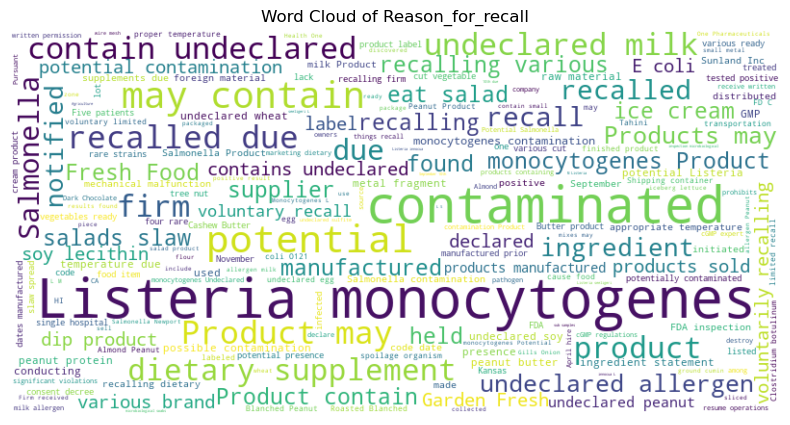

In [47]:
text_col = 'reason_for_recall'

# Concatenate all the text from the selected column
text = ' '.join(fda_df_cleaned[text_col].dropna().tolist())

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Create a plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_title('Word Cloud of ' + text_col.capitalize())
ax.axis('off')

# Display the plot
plt.show()

#### 2) What are the top 10 recalling firms with the highest number of recalls?

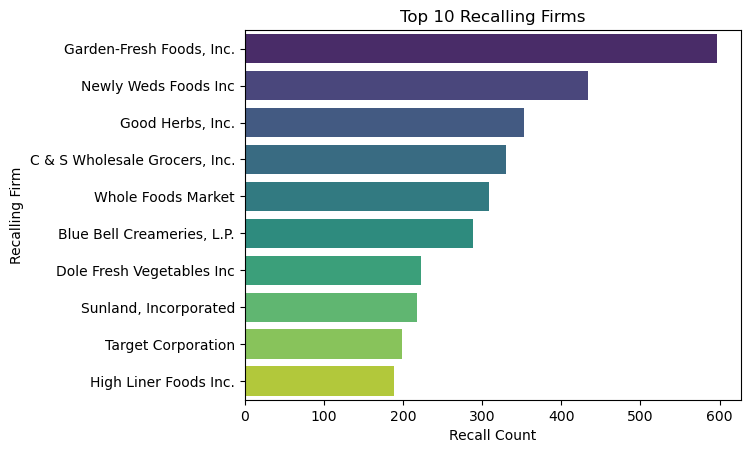

In [48]:
# Get the top 10 recalling firms
top_10_recalling_firms = fda_df_cleaned['recalling_firm'].value_counts().head(10)

# Create a bar chart
sns.barplot(x=top_10_recalling_firms.values, y=top_10_recalling_firms.index, palette='viridis')
plt.title('Top 10 Recalling Firms')
plt.xlabel('Recall Count')
plt.ylabel('Recalling Firm')
plt.show()

#### 3) What is the distribution of recalling firms across different initial firm notification categories? Which notification category has the highest number of firms, and which one has the lowest number of firms?

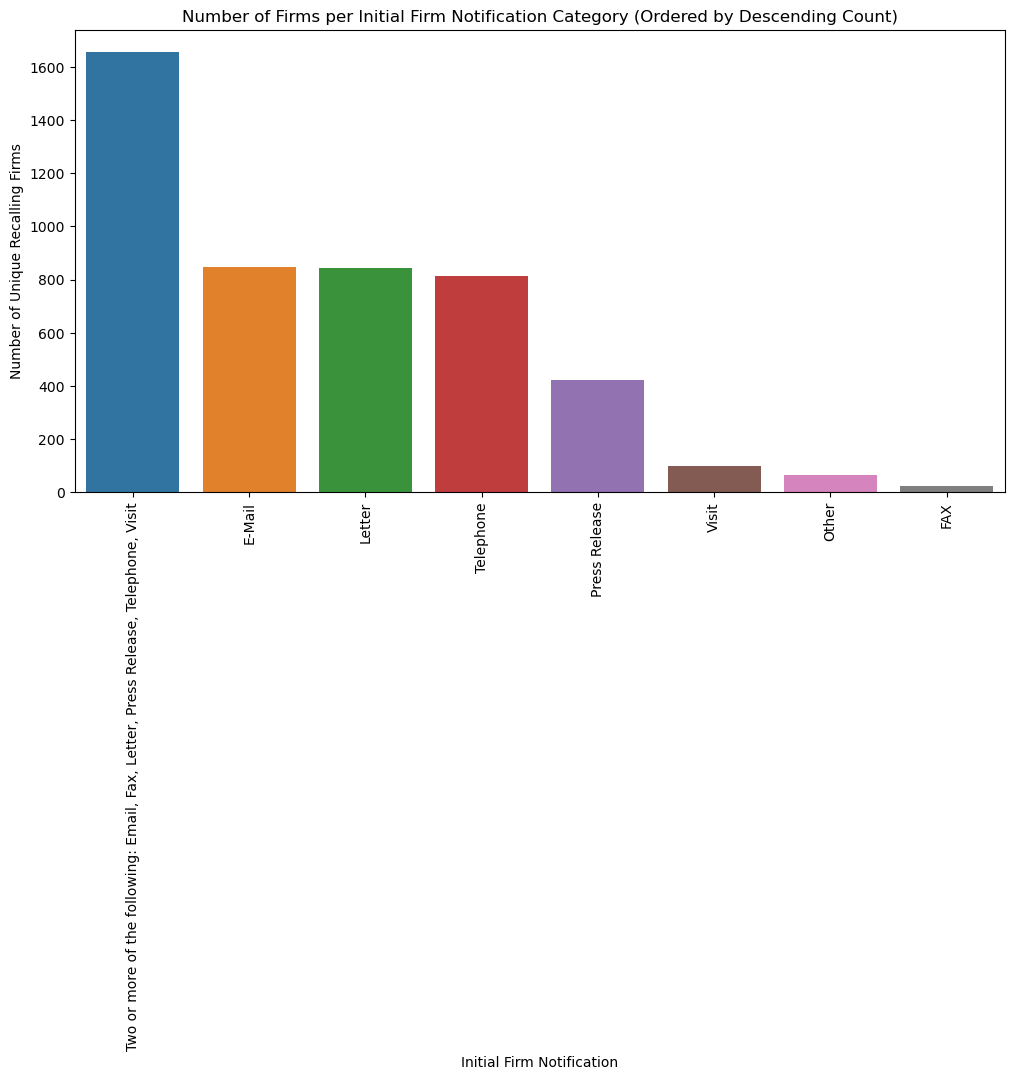

In [49]:
# Group by initial firm notification and count the number of unique firms in each category
firms_per_notification = fda_df_cleaned.groupby('initial_firm_notification')['recalling_firm'].nunique()

# Sort by number of firms in descending order
firms_per_notification = firms_per_notification.sort_values(ascending=False)

# Create a bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=firms_per_notification.index, y=firms_per_notification.values)
plt.xlabel('Initial Firm Notification')
plt.ylabel('Number of Unique Recalling Firms')
plt.title('Number of Firms per Initial Firm Notification Category (Ordered by Descending Count)')
plt.xticks(rotation=90)
plt.show()

#### 4) What are the trends or patterns of recalls over time i.e. How has the number of recalls changed over time? Are there any noticeable spikes or dips in recall activities?

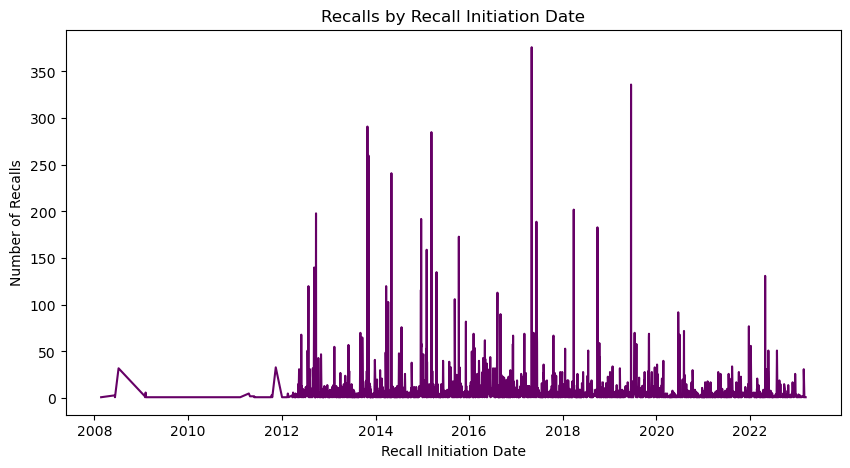

In [50]:
# Group the data by date and count the number of recalls in each date
recall_initiation_date_counts = fda_df_cleaned['recall_initiation_date'].value_counts().sort_index()

# Create a time series plot for Recall Initiation Date
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(recall_initiation_date_counts.index, recall_initiation_date_counts.values, color="#660066")
ax.set_title('Recalls by Recall Initiation Date')
ax.set_xlabel('Recall Initiation Date')
ax.set_ylabel('Number of Recalls')

# Display the plots
plt.show()

#### 5) What is the distribution of product recalls by month in the past year? Months that experienced higher recall activity compared to others.

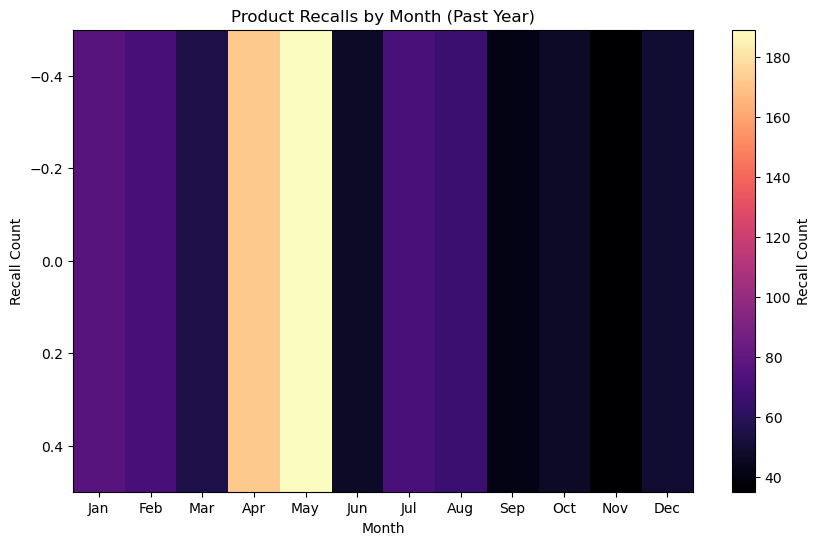

In [51]:
# Calculate the past year date range
current_year = pd.Timestamp.now().year
past_year_start = pd.Timestamp(year=current_year-1, month=1, day=1)
past_year_end = pd.Timestamp(year=current_year-1, month=12, day=31)

# Filter the data for the past year
filtered_data = fda_df_cleaned[
    (fda_df_cleaned['recall_initiation_date'] >= past_year_start) &
    (fda_df_cleaned['recall_initiation_date'] <= past_year_end)
]

# Group the filtered data by month and count the occurrences
monthly_recalls = filtered_data['recall_initiation_date'].dt.month.value_counts().sort_index()

# Create a 2D array for the heat map data
heat_map_data = np.zeros((12,))
for month, count in monthly_recalls.items():
    heat_map_data[month-1] = count

# Create the heat map
plt.figure(figsize=(10, 6))  # Set the figure size
plt.imshow([heat_map_data], cmap='magma', aspect='auto', interpolation='nearest')  # Plot the heat map
plt.colorbar(label='Recall Count')  # Add a colorbar with label
plt.title('Product Recalls by Month (Past Year)')  # Set the title of the chart
plt.xlabel('Month')  # Set the x-axis label
plt.xticks(np.arange(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])  # Set x-axis tick labels
plt.ylabel('Recall Count')  # Set the y-axis label
plt.show()  # Show the plot

#### 6) What are the top 50 event IDs with the most recalls?

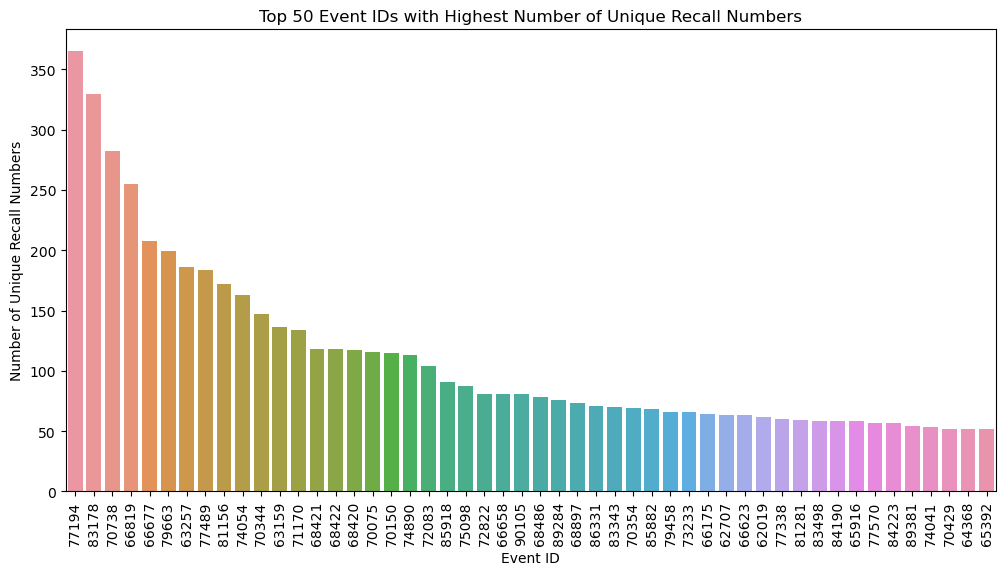

In [52]:
# Group by event ID and count the unique recall numbers
event_recall_counts = fda_df_cleaned.groupby('event_id')['recall_number_digits'].nunique().reset_index()

# Sort by recall counts in descending order and select the top 50 event IDs
top_50_event_ids = event_recall_counts.sort_values('recall_number_digits', ascending=False).head(50)

# Create a count plot
plt.figure(figsize=(12, 6))
sns.barplot(x='event_id', y='recall_number_digits', data=top_50_event_ids)
plt.xlabel('Event ID')
plt.ylabel('Number of Unique Recall Numbers')
plt.title('Top 50 Event IDs with Highest Number of Unique Recall Numbers')
plt.xticks(rotation=90)
plt.show()

#### 7) Which classification category (risk level indicator), has the highest or lowest percentage of recalls?

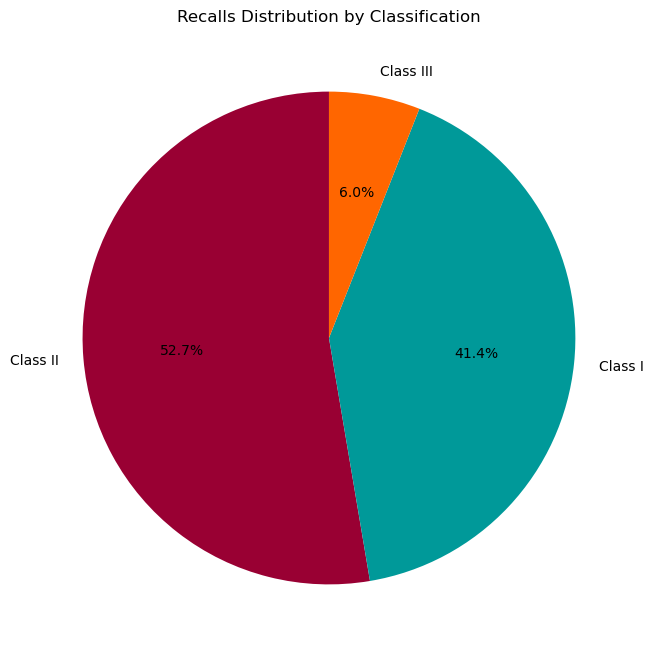

In [53]:
# Count recalls by classification
df_counts = fda_df_cleaned['classification'].value_counts()

custom_colors = ["#990033", "#009999", "#ff6600", "#33cc33", "#333399"]

# Pie chart
plt.figure(figsize=(8, 8)) # Set figure size
plt.pie(df_counts.values, labels=df_counts.index, autopct='%1.1f%%', startangle=90, colors=custom_colors) # Create pie chart
plt.title('Recalls Distribution by Classification') # Set plot title
plt.show() # Show plot